In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from config import *
TPU_MODE=False

import dataset_functions as df
import importlib
import tensorflow as tf
importlib.reload(df)

<module 'dataset_functions' from 'C:\\Users\\flash\\Project\\Yet-Another-Openpose-Implmentation\\dataset_functions.py'>

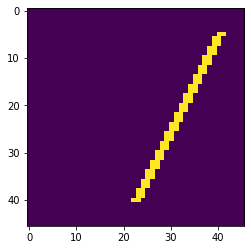

In [2]:
lt=df.LabelTransformer()
new_j=np.zeros((19,1,5),dtype=np.float32)
new_j[0,...,0]=0.1
new_j[0,...,1]=0.9
new_j[0,...,2]=0.9
new_j[0,...,3]=0.5
new_j[0,...,4]=2
new_j=tf.ragged.constant(new_j)
paf=lt.joints_PAFs(new_j)
plt.imshow(paf.numpy().max(axis=-1))

In [5]:
class LabelTransformer():
    def __init__(self):
        y_grid=tf.linspace(0.0,1.0,LABEL_HEIGHT)
        x_grid=tf.linspace(0.0,1.0,LABEL_WIDTH)
        yy,xx=tf.meshgrid(y_grid,x_grid,indexing='ij') #indexing is a must, otherwise, it's just bizzare!
        self.grid=tf.stack((yy,xx),axis=-1)
    
    def single_PAF(self, joint):
        """ Makes a single vector valued PAF (part affinity field) array
        *does not support batched input
        :return a tensor of shape (LABEL_HEIGHT, LABEL_WIDTH, 2)
        """  
        jpts = tf.reshape(joint[0:4], (2, 2))  # reshape to ((x1,y1),(x2,y2))
        if joint[4] == tf.constant(0.0):
            return tf.zeros((LABEL_HEIGHT, LABEL_WIDTH, 2), dtype=tf.float32)  # in case of empty joint
        else:
            # this follows the OpenPose paper ofr generating the PAFs
            vector_full = jpts[1] - jpts[0]  # get the joint vector
            vector_length = tf.linalg.norm(vector_full)  # get joint length
            vector_hat = vector_full / vector_length  # get joint unit vector
    
            grid_vectors = self.grid - jpts[0]  # get grid of vectors from first joint point
            projections = tf.tensordot(grid_vectors, vector_hat, 1)  # get projection on the joint unit vector
    
            normal_vector = tf.stack((-vector_hat[1], vector_hat[0]))
            n_projections = tf.tensordot(grid_vectors, normal_vector, 1)  # get projection on the joint normal unit vector
            na_projections = tf.abs(n_projections)  # absolute value to get both sides of rhe joint
    
            limit = (0 <= projections) & (projections <= vector_length) & (na_projections <= JOINT_WIDTH)
    
            limit_brdcst = tf.stack((limit, limit), axis=-1)  # this is for broadcasting to the 2 tuple
    
            return tf.where(limit_brdcst, vector_hat, tf.constant((0.0, 0.0)))

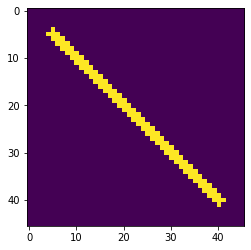

In [9]:
lt=LabelTransformer()

j1=tf.constant((0.1,0.1,0.9,0.9,2),dtype=tf.float32)
paf=lt.single_PAF(j1)
plt.imshow(paf[...,0])